# Coursera Capstone Project

This notebook contains the code for the Coursera Capstone Project on Data Science by IBM and Coursera

### Importing required libraries

In [1]:
# Download beautifulsoup4 library for webscraping, if not installed
# !conda install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv 

### Setting `maxcolwidth` to `800` for good viewability

In [2]:
pd.set_option('max_colwidth', 800) 

### Getting the source webpage and assigining the variable `source` to it and iniatilizing the `beautifulsoup` object to `soup`

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Kolkata').text 
soup = BeautifulSoup(source, 'lxml')

### Initializing the `csv_writer` object and writing the name of the columns on it as the first row

In [4]:
csv_file = open('kolkata.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

### Scraping the page to extracting the list of neighbourhoods in Kolkata

In [5]:
mwcg = soup.find_all(class_ = "mw-category-group")

length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(1, length):  # Gets all the neighbourhoods
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd]) # Writes the name of the neighbourhood in the csv file    

### Closing the csv file

In [6]:
csv_file.close()

### Creating the pandas dataframe

In [7]:
df = pd.read_csv('kolkata.csv')

### Getting the number of neighbourhoods in Kolkata

In [8]:
df.shape

(199, 1)

### Google Maps Geocoding API credentials

In [9]:
# The code was removed by Watson Studio for sharing.

### Using the Google Maps Geocoding API 

In [10]:
import json

latitudes = [] # Initializing the latitude array
longitudes = [] # Initializing the longitude array

for nbd in df["Neighbourhood"] : 
    place_name = nbd + ",Kolkata,India" # Formats the place name
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(place_name, API_KEY) # Gets the proper url to make the API call
    obj = json.loads(requests.get(url).text) # Loads the JSON file in the form of a python dictionary
    
    results = obj['results'] # Extracts the results information out of the JSON file
    lat = results[0]['geometry']['location']['lat'] # Extracts the latitude value
    lng = results[0]['geometry']['location']['lng'] # Extracts the longitude value
    
    latitudes.append(lat) # Appending to the list of latitudes
    longitudes.append(lng) # Appending to the list of longitudes 

### Adding the latitude and longitude values to the dataframe

In [11]:
df['Latitude'] = latitudes
df['Longitude'] = longitudes

In [12]:
df.head()

,Neighbourhood,Latitude,Longitude
0,Abhirampur,22.465008,88.169386
1,Agarpara,22.683442,88.393118
2,Ajoy Nagar,22.489009,88.396147
3,Alipore,22.525178,88.330863
4,"Alipur, Jaynagar",22.525178,88.330863


### Judging the performance of the API using the number of collisions

In [13]:
col = 0
explored_lat_lng = []
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    if (lat, lng) in explored_lat_lng:
        col = col + 1
    else:
        explored_lat_lng.append((lat, lng))

print("Collisions : ", col)

Collisions :  8


### Importing other libraries 

In [14]:
# Downloading folium, if not installed
!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map plotting library
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

# All requested packages already installed.



### FourSquare API Credentials

In [15]:
# The code was removed by Watson Studio for sharing.

### Creating a folium map of Kolkata

In [16]:
# Kolkata latitude and longitude using Google search
kol_lat = 22.5726
kol_lng = 88.3639

# Creates map of Kolkata using latitude and longitude values
map_kolkata = folium.Map(location=[kol_lat, kol_lng], zoom_start=10)

# Add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kolkata)  
    
map_kolkata

### Defining own function to get the name of the category

In [17]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Using the FourSquare API on all neighbourhoods

In [18]:
explore_df_list = []

for i, nbd_name in enumerate(df['Neighbourhood']):  
    
    try :
        ### Getting the data of neighbourhood
        nbd_name = df.loc[i, 'Neighbourhood']
        nbd_lat = df.loc[i, 'Latitude']
        nbd_lng = df.loc[i, 'Longitude']

        radius = 1000 # Setting the radius as 1000 metres
        LIMIT = 30 # Getting the top 30 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON

        # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

### Creating a dataframe for performing clustering operations

In [19]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Agarpara,22.683442,88.393118,Axis Bank ATM,ATM,22.682870,88.394290
1,Agarpara,22.683442,88.393118,Agarpara Railway Station,Train Station,22.682886,88.385364
2,Agarpara,22.683442,88.393118,Apollo Pharmacy,Pharmacy,22.681864,88.384347
3,Ajoy Nagar,22.489009,88.396147,Metro Cash and Carry,Grocery Store,22.495497,88.398711
4,Ajoy Nagar,22.489009,88.396147,Inox,Multiplex,22.483197,88.390803


### Performing one-hot encoding to analyze neighbourhoods

In [20]:
# One hot encoding
kolkata_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
kolkata_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

# Move neighborhood column to the first column
fixed_columns = [kolkata_onehot.columns[-1]] + kolkata_onehot.columns[:-1].values.tolist()
kolkata_onehot = kolkata_onehot[fixed_columns]

kolkata_onehot.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Watch Shop,Women's Store
0,Agarpara,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agarpara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Agarpara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ajoy Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ajoy Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Aggregating venues by neighbourhoods

In [21]:
kolkata_grouped = kolkata_onehot.groupby('Neighbourhood').mean().reset_index()
kolkata_grouped.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Watch Shop,Women's Store
0,Agarpara,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
1,Ajoy Nagar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Alipore,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,"Alipur, Jaynagar",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Amodghata,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Creating a function to return the most common venues

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating a new dataframe to get the top 10 venues

In [23]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = kolkata_grouped['Neighbourhood']

for ind in np.arange(kolkata_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kolkata_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agarpara,ATM,Train Station,Pharmacy,Airport,Flea Market,Cricket Ground,Department Store,Dessert Shop,Dhaba,Diner
1,Ajoy Nagar,Shopping Mall,Multiplex,Bakery,Grocery Store,Bus Station,Department Store,Diner,Dumpling Restaurant,Dhaba,Dessert Shop
2,Alipore,Dessert Shop,South Indian Restaurant,Hotel,Chinese Restaurant,Pizza Place,Café,Italian Restaurant,Garden,Athletics & Sports,Women's Store
3,"Alipur, Jaynagar",Dessert Shop,South Indian Restaurant,Hotel,Chinese Restaurant,Pizza Place,Café,Italian Restaurant,Garden,Athletics & Sports,Women's Store
4,Amodghata,Pharmacy,Electronics Store,Film Studio,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant,Concert Hall


### Setting the dataframe for k-means clustering to operate on 

In [24]:
kolkata_grouped_clustering = kolkata_grouped.drop('Neighbourhood', 1)

### Using K-Means clustering

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [26]:
max_range = 20 # Maximum range of clusters

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = kolkata_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

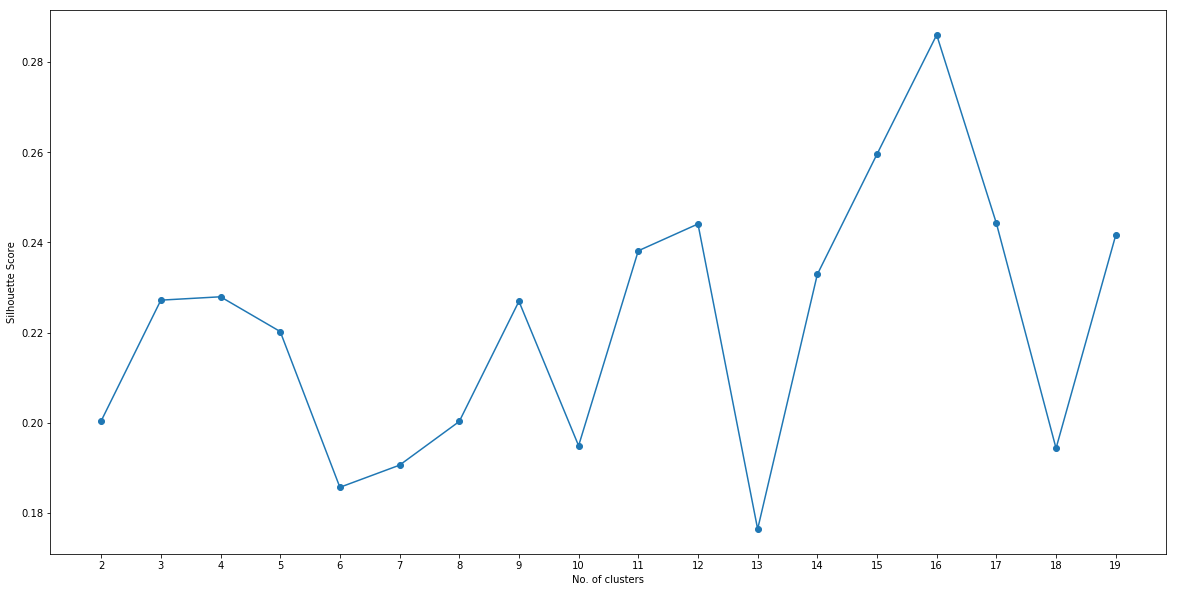

In [28]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### From the graph the optimal number is found out to be considered for our clustering

In [29]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

16

### K-Means clustering for the optimal number of clusters

In [30]:
kclusters = opt

# Run k-means clustering
kgc = kolkata_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

In [31]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### Creating a grand dataframe containing the necessary data

In [32]:
kolkata_merged = df
kolkata_merged = kolkata_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
kolkata_merged.dropna(inplace = True)
kolkata_merged['Cluster Labels'] = kolkata_merged['Cluster Labels'].astype(int)
kolkata_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Agarpara,22.683442,88.393118,12,ATM,Train Station,Pharmacy,Airport,Flea Market,Cricket Ground,Department Store,Dessert Shop,Dhaba,Diner
2,Ajoy Nagar,22.489009,88.396147,4,Shopping Mall,Multiplex,Bakery,Grocery Store,Bus Station,Department Store,Diner,Dumpling Restaurant,Dhaba,Dessert Shop
3,Alipore,22.525178,88.330863,4,Dessert Shop,South Indian Restaurant,Hotel,Chinese Restaurant,Pizza Place,Café,Italian Restaurant,Garden,Athletics & Sports,Women's Store
4,"Alipur, Jaynagar",22.525178,88.330863,4,Dessert Shop,South Indian Restaurant,Hotel,Chinese Restaurant,Pizza Place,Café,Italian Restaurant,Garden,Athletics & Sports,Women's Store
5,Amodghata,22.988505,88.380986,9,Pharmacy,Electronics Store,Film Studio,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant,Concert Hall


### Visualizing the clusters

In [33]:
# Create map
map_clusters = folium.Map(location=[kol_lat, kol_lng], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kolkata_merged['Latitude'], kolkata_merged['Longitude'], kolkata_merged['Neighbourhood'], kolkata_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

In [56]:
val = 14
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == (val - 1), kolkata_merged.columns[[0] + np.arange(4, kolkata_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,"Bijpur, North 24 Parganas",Train Station,Women's Store,Electronics Store,Film Studio,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant
123,Garshyamnagar,Train Station,Platform,Women's Store,Eastern European Restaurant,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Electronics Store
131,Halisahar,Train Station,Women's Store,Electronics Store,Film Studio,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant
141,Hind Motor,Light Rail Station,Train Station,Women's Store,Electronics Store,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant
186,Kodalia,Train Station,Women's Store,Electronics Store,Film Studio,Field,Fast Food Restaurant,Falafel Restaurant,Fabric Shop,Event Service,Eastern European Restaurant
